In [62]:
%load_ext autoreload
%autoreload 2

import os
import time
import cv2
import torch
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from scripts.utils import np_to_tesor_img, tensor_to_np_img, save_tensor_img, open_img_as_tensor, display_img

## Face Detector Models

In [3]:
from scripts.face_detectors import MediaPipe, YuNet, YoloFace

In [94]:
mp = MediaPipe()
yn = YuNet()
yf = YoloFace(conf=0.9)

## Our Model

In [6]:
from scripts.iarm import *
iarm = IARM()

## Image Feature Extraction

In [10]:
from scripts import image_attributes

In [12]:
# Settings
image_attributes.save_color_images = False
image_attributes.save_lbp_images = False
image_attributes.save_gradient_images = False

## FGSM

Model for feature extraction

In [13]:
print("CUDA Available: ", torch.cuda.is_available())
main_yf = YoloFace()
device, model = main_yf.device, main_yf.yf_face_detector
model.eval()

CUDA Available:  False


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [11]:
from scripts import fgsm

Sample attack without mask

In [109]:
input_file = r"./input/sample1.jpg"

Our regression model run time: 17.24525547027588


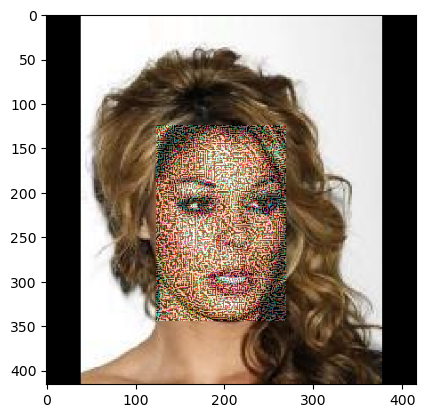

In [100]:
t1 = time.time()

input_img = open_img_as_tensor(input_file)
feats, grads, bboxes, masks = image_attributes.get_features(input_file)
preds = iarm.predict(feats)
output_img = fgsm.fgsm_attack(input_img, preds, grads, masks)

t2 = time.time()

print("Our regression model run time:", t2 - t1)
display_img(output_img)

Sample attack with mask

In [119]:
input_file = r"./input/sample2.jpg"

Our regression model run time: 19.15131449699402


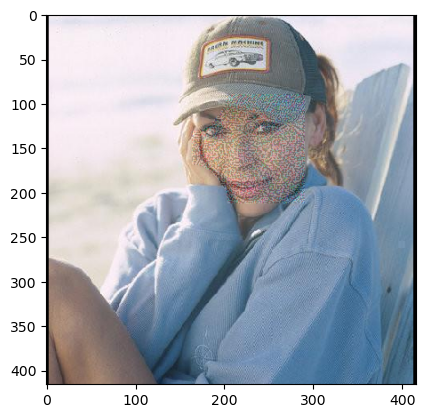

In [121]:
from scripts.facesegmentor import FaceSegementor
faceseg = FaceSegementor()

t1 = time.time()

input_img = open_img_as_tensor(input_file)
feats, grads, bboxes, masks = image_attributes.get_features(input_file, face_segmentor=faceseg)
preds = iarm.predict(feats)
output_img = fgsm.fgsm_attack(input_img, preds, grads, masks)

t2 = time.time()

print("Our regression model run time:", t2 - t1)
display_img(output_img)

Compare with binary search

In [135]:
input_file = r"./input/sample3.jpg"

In [ ]:
t1 = time.time()

input_img = open_img_as_tensor(input_file)
_, grads, bboxes, masks = image_attributes.get_features(input_file)
e_mins = []

for data_grad, mask, bbox in zip(grads, masks, bboxes):
    e_mins.append(fgsm.binary_search(input_img, data_grad, yf, mask, bbox))

output_img = fgsm.fgsm_attack(input_img, e_mins, grads, masks)

t2 = time.time()

print("Our regression model run time:", t2 - t1)
display_img(output_img)

Check if the faces can still be detected

In [127]:
input_file = r"./input/sample1.jpg"

In [128]:
input_img = open_img_as_tensor(input_file)
feats, grads, bboxes, masks = image_attributes.get_features(input_file)
preds = iarm.predict(feats, multiplier=2.5)
output_img = fgsm.fgsm_attack(input_img, preds, grads, masks)

yf.detect("Detected faces:", output_img)

[]

In [131]:
input_file = r"./input/sample2.jpg"

In [132]:
input_img = open_img_as_tensor(input_file)
feats, grads, bboxes, masks = image_attributes.get_features(input_file)
preds = iarm.predict(feats, multiplier=2.5)
output_img = fgsm.fgsm_attack(input_img, preds, grads, masks)

yf.detect("Detected faces:", output_img)

[]

##### ___